In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,12)
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

np.random.seed(5)

In [26]:
time_steps = 3
n_features = 1
n_epochs = 60
DATASET = "papas_g2.csv"

In [27]:
def create_dataset(dataset, time_steps=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_steps-1):
		a = dataset[i:(i+time_steps), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_steps, 0])
	return np.array(dataX), np.array(dataY)

In [28]:
data = pd.read_csv('../Data/Processed/'+DATASET, engine='python')


In [29]:
model = Sequential()
model.add(LSTM(4, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

testSets = {}
crops = data["producto"].unique().tolist()
for crop in crops:
    cropData = data[data.producto == crop]["precio_mean"]

    dataset = cropData.values
    dataset = dataset.astype("float32")

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    train = dataset[0 : int(dataset.shape[0] * 0.8), :]
    test = dataset[int(dataset.shape[0] * 0.8) : len(dataset), :]

    trainX, trainY = create_dataset(train, time_steps)
    testX, testY = create_dataset(test, time_steps)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    model.fit(trainX, trainY, epochs=n_epochs, batch_size=1, verbose=2)

    testSets[crop] = {
        "trainX": trainX,
        "trainY": trainY,
        "testX": testX,
        "testY": testY,
        "scaler": scaler,
        "dataset": dataset,
    }


Epoch 1/60
2552/2552 - 3s - loss: 0.0019 - 3s/epoch - 1ms/step
Epoch 2/60
2552/2552 - 2s - loss: 0.0012 - 2s/epoch - 852us/step
Epoch 3/60
2552/2552 - 2s - loss: 9.5419e-04 - 2s/epoch - 832us/step
Epoch 4/60
2552/2552 - 2s - loss: 8.8246e-04 - 2s/epoch - 834us/step
Epoch 5/60
2552/2552 - 2s - loss: 8.8745e-04 - 2s/epoch - 825us/step
Epoch 6/60
2552/2552 - 2s - loss: 8.3634e-04 - 2s/epoch - 832us/step
Epoch 7/60
2552/2552 - 2s - loss: 8.3466e-04 - 2s/epoch - 844us/step
Epoch 8/60
2552/2552 - 2s - loss: 8.0207e-04 - 2s/epoch - 850us/step
Epoch 9/60
2552/2552 - 2s - loss: 8.1747e-04 - 2s/epoch - 813us/step
Epoch 10/60
2552/2552 - 2s - loss: 8.0657e-04 - 2s/epoch - 838us/step
Epoch 11/60
2552/2552 - 2s - loss: 7.8515e-04 - 2s/epoch - 844us/step
Epoch 12/60
2552/2552 - 2s - loss: 7.7772e-04 - 2s/epoch - 817us/step
Epoch 13/60
2552/2552 - 2s - loss: 7.6570e-04 - 2s/epoch - 825us/step
Epoch 14/60
2552/2552 - 2s - loss: 7.7731e-04 - 2s/epoch - 832us/step
Epoch 15/60
2552/2552 - 2s - loss: 7.62

KeyboardInterrupt: 

20/20 [==============================] - 0s 632us/step
PAPA BLANCA/VALLE/OTROS
Train Score: 0.0425 MAPE
Test Score: 0.0238 MAPE


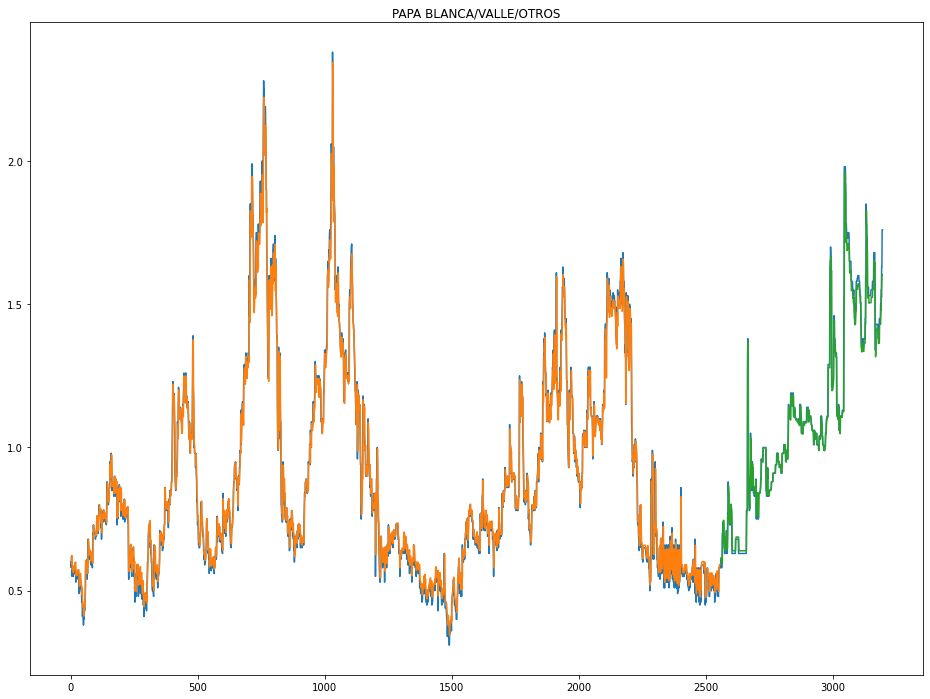

20/20 [==============================] - 0s 579us/step
PAPA COLOR/VALLE/OTROS
Train Score: 0.0350 MAPE
Test Score: 0.0233 MAPE


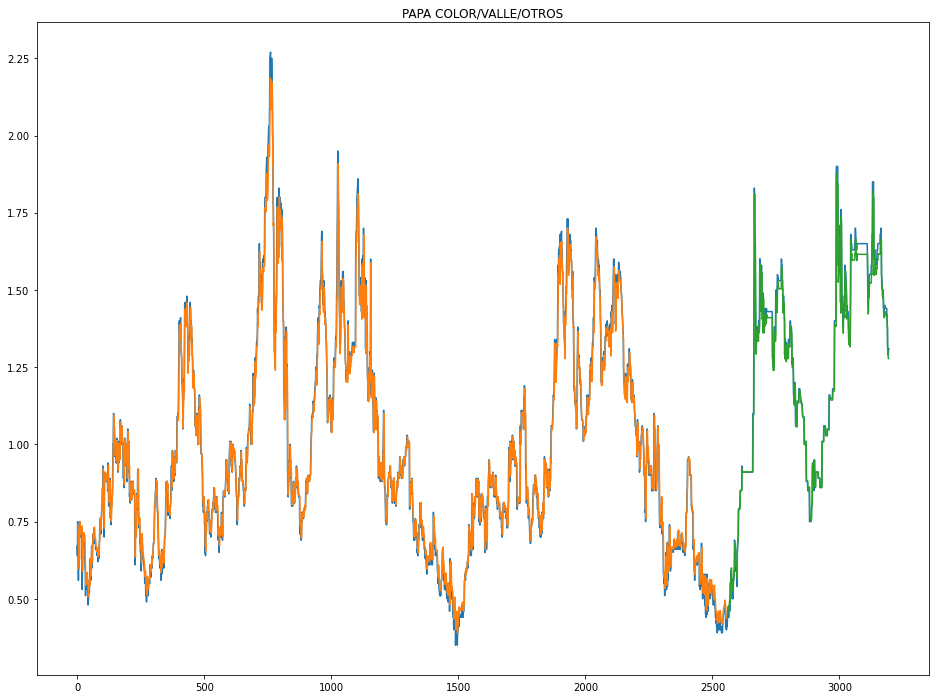

20/20 [==============================] - 0s 605us/step
PAPA NEGRA ANDINA
Train Score: 0.0389 MAPE
Test Score: 0.0210 MAPE


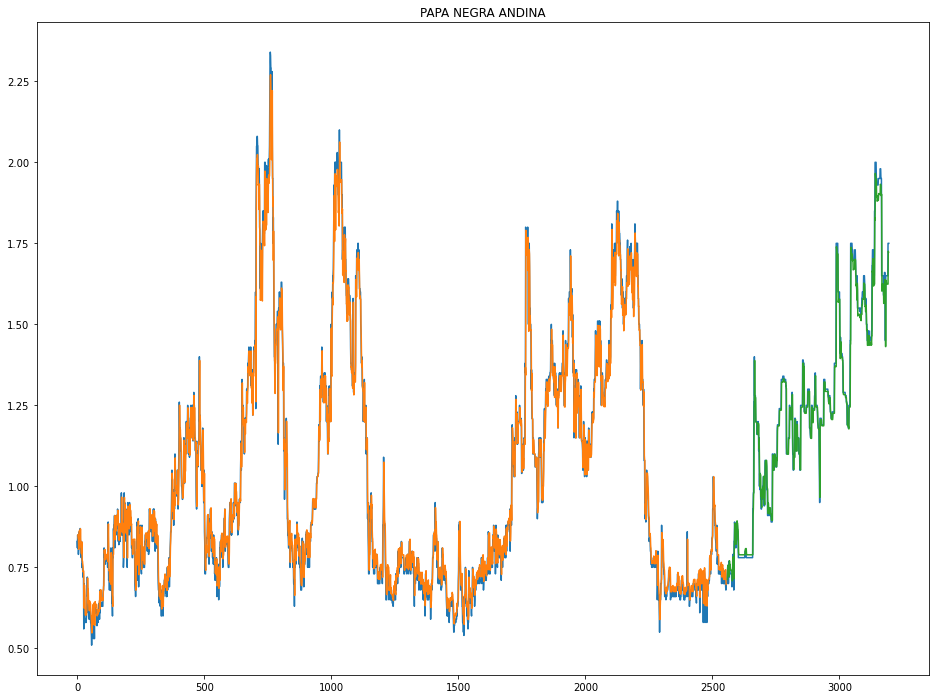

20/20 [==============================] - 0s 658us/step
PAPA YUNGAY
Train Score: 0.0442 MAPE
Test Score: 0.0236 MAPE


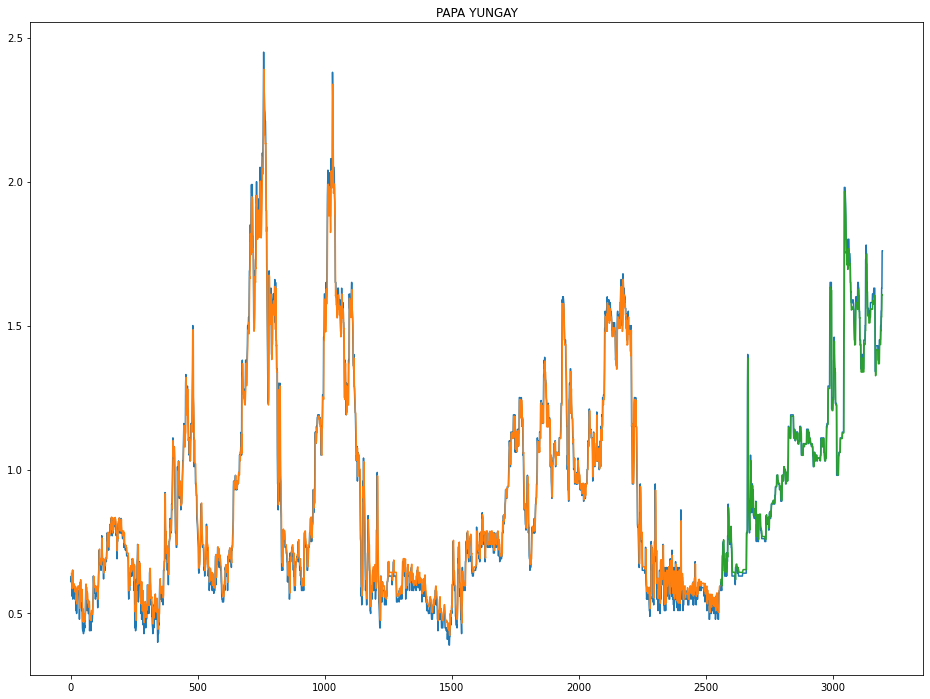

20/20 [==============================] - 0s 605us/step
PAPA UNICA
Train Score: 0.0436 MAPE
Test Score: 0.0297 MAPE


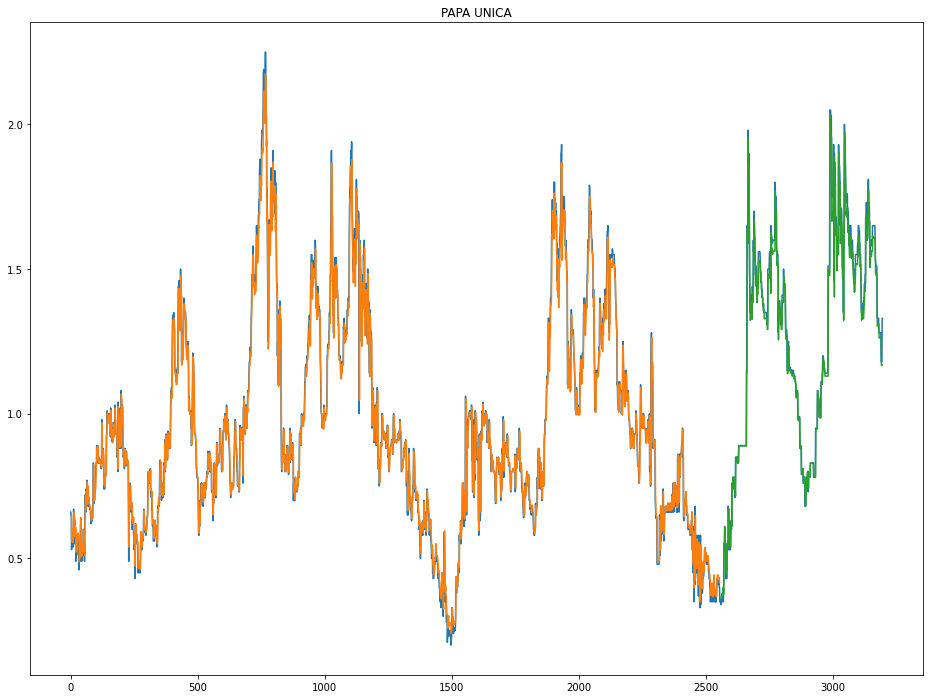

20/20 [==============================] - 0s 605us/step
PAPA CANCHAN
Train Score: 0.0371 MAPE
Test Score: 0.0200 MAPE


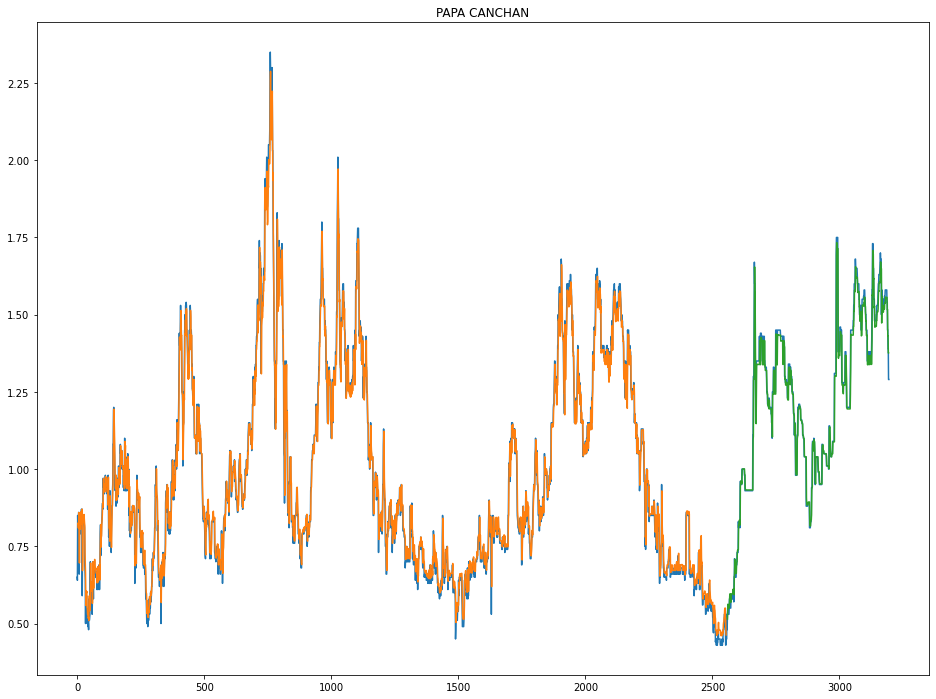

<Figure size 1152x864 with 0 Axes>

In [ ]:
for crop in testSets:
    trainPredict = model.predict(testSets[crop]['trainX'])
    testPredict = model.predict(testSets[crop]['testX'])

    trainPredict = testSets[crop]['scaler'].inverse_transform(trainPredict)
    trainY = testSets[crop]['scaler'].inverse_transform([testSets[crop]['trainY']])
    testPredict = testSets[crop]['scaler'].inverse_transform(testPredict)
    testY = testSets[crop]['scaler'].inverse_transform([testSets[crop]['testY']])
    actualData = testSets[crop]['scaler'].inverse_transform(testSets[crop]['dataset'])
    
    print(crop)
    trainScore = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
    print('Train Score: %.4f MAPE' % (trainScore))
    testScore = mean_absolute_percentage_error(testY[0], testPredict[:,0])
    print('Test Score: %.4f MAPE' % (testScore))

    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_steps:len(trainPredict)+time_steps, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(time_steps*2)+1:len(dataset)-1, :] = testPredict

    plt.title(crop)
    plt.plot(actualData)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()